In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import illustris_python as il

#constants
h_tng = 0.678 #Planck 2015
h_sami = 0.7
h_b = 0.7 #behroozi
h_z = 0.7 #Zanisi
G = 4.3*10**(-6) #  kpc/M_o*(km/s)**2

In [2]:
def masses(df):
    keys = df.keys()
    for key in keys:
        if "Mass" in key:
            df[key] = df[key]*10**10/h_tng
    return df

def color(df):
    bands = ["g", "r", "i"]
    for i in range(3):
        for j in range(i+1, 3):
            key1 = "SubhaloStellarPhotometrics_" + bands[i]
            key2 = "SubhaloStellarPhotometrics_" + bands[j]
            for key in df.keys():
                if (key1 in key):
                    radkey = key.replace(key1, "")
                    if (key2 + radkey) in df.keys():
                        df["SubhaloColor_" + bands[i] + "-" + bands[j] + radkey] = df[key1 + radkey] - df[key2 + radkey]
    return df

def double_power_law(b, c, M1, N):
    xmin, xmax = 9, 14
    x=np.logspace(xmin,xmax,200)
    y = 2*N*x*((x/M1)**(-b)+(x/M1)**(c))**(-1)
    return x,y

def power_law_log (C, a, xmin, xmax):
    y = np.logspace(xmin, xmax)
    x = a*np.log10(y) + C
    return 10**x, y
    
def behroozi(a, M1, c, d, e):
    def f(x):
        f = -np.log10(10**(a*x)+1)+d*((np.log10(1+np.exp(x)))**c)/(1+np.exp(10**(-x)))
        return f
    xmin, xmax = 9, 14
    X=np.logspace(xmin,xmax,200)
    Y_log = np.log10(e*M1)+f(np.log10(X/M1)) - f(0) #gives log(y)
    return X, 10**(Y_log)

In [3]:
def late_type_SFR(df):
    df_copy = df.copy(deep=True)
    index_names = df_copy[df_copy["SubhalosSFR"] < 0.036].index
    df_copy = df_copy.drop(index_names)
    
    return df_copy

def early_type_SFR(df):
    df_copy = df.copy(deep=True)
    index_names = df_copy[df_copy["SubhalosSFR"] > 0.01148].index
    df_copy = df_copy.drop(index_names)
    return df_copy

def late_type_gas(df):
    df_copy = df.copy(deep=True)
    index_names = df_copy[df_copy["SubhaloGasFraction"] < 0.1].index #Ferrero2020
    df_copy = df_copy.drop(index_names)
    return df_copy

def early_type_gas(df):
    df_copy = df.copy(deep=True)
    index_names = df_copy[df_copy["SubhaloGasFraction"] > 0.1].index #Ferrero2020
    df_copy = df_copy.drop(index_names)
    return df_copy

def late_type_kappa(df):
    df_copy = df.copy(deep=True)
    index_names = df_copy[df_copy["Kappa_rot"] < 0.6].index #Ferrero2020
    df_copy = df_copy.drop(index_names)
    return df_copy

def early_type_kappa(df):
    df_copy = df.copy(deep=True)
    index_names = df_copy[df_copy["Kappa_rot"] > 0.6].index #Ferrero2020
    df_copy = df_copy.drop(index_names)
    return df_copy

def clean_subhalos(df, idlist):
    df_copy = df.copy(deep=True)
    index_names = np.array([])
    df_id = np.array(df_copy["id"])
    for item in df_id:
        if item not in idlist:
            print(item)
            index_names = np.append(index_names, df_copy[df_copy["id"]==item].index)
    print(index_names)
    df_copy = df_copy.drop(index_names)
    return df_copy

In [4]:
old = pd.read_pickle("../data/tng-100-1/cutdata/Subhalo_Centrals_minE9_5_SM.pkl")
general = pd.read_pickle("../data/tng-100-1/catalogues/mass_vel_photo_2303.pkl")
vel = pd.read_pickle("../data/tng-100-1/catalogues/velocities_1903.pkl")
aper1 = pd.read_pickle("../data/tng-100-1/catalogues/apertures_0704.pkl")
aper2 = pd.read_pickle("../data/tng-100-1/catalogues/30_10_apertures1504.pkl")
aper = aper1.join(aper2, lsuffix="DROP").filter(regex="^(?!.*DROP)")

new1 = general.join(vel, lsuffix="DROP").filter(regex="^(?!.*DROP)")
new = aper.join(new1, lsuffix="DROP").filter(regex="^(?!.*DROP)")
sami = pd.read_csv("../data/SAMI/dr3.csv")
sami_dr2 = pd.read_csv("../data/SAMI/all_data_vrot_dr2.csv")
old.sort_values(by="id", inplace = True)
new.sort_values(by="id", inplace = True)
new = clean_subhalos(new, list(old["id"]))

print(len(old), len(new), len(vel))

#Masses
old = masses(old)
new = masses(new)

#sSFR and gas fraction
new["SubhalosSFR"] = 10**(9)*new["SubhaloSFR"]/new["SubhaloMassStellar"]
new["SubhaloGasFraction"] = new["SubhaloMassInHalfRadGas"]/new["SubhaloMassInHalfRadStellar"]

old["SubhalosSFR"] = 10**(9)*old["SubhaloSFR"]/old["SubhaloMassStellar"]
old["SubhaloGasFraction"] = old["SubhaloMassGas"]/old["SubhaloMassStellar"]

#Half mass rad

new["SubhaloHalfmassRadProjTotal"] = ((new["SubhaloHalfmassRad_xy_Total"]**2 + new["SubhaloHalfmassRad_xz_Total"]**2 + new["SubhaloHalfmassRad_yz_Total"]**2)*(1/3))**(1/2)
new["SubhaloHalfmassRadProj30kpc"] = ((new["SubhaloHalfmassRad_xy30kpc"]**2 + new["SubhaloHalfmassRad_xz30kpc"]**2 + new["SubhaloHalfmassRad_yz30kpc"]**2)*(1/3))**(1/2)

for key in new.keys():
    if "SubhaloHalfmassRad" in key:
        new[key] = new[key]/h_tng
for key in old.keys():
    if "SubhaloHalfmassRad" in key:
        old[key] = old[key]/h_tng

#Adding color
new = color(new)
old = color(old)


464331
469502
485326
489356
[1132. 1215. 1496. 1579.]
5873 5873 5877


In [5]:
sami["mstar"] = sami["mstar"]*h_sami**2/(h_tng**2)
sami["r_e_circ"] = sami["r_e_circ"]*h_sami/h_tng
sami["r_e"] = sami["r_e"]*h_sami/h_tng
sami["r_mge"] = sami["r_mge"]*h_sami/h_tng

In [6]:
for key in new.keys():
    if "3D" in key:
        new_key = key.replace("3D", "1D")
        new[new_key] = new[key]*(1/3)**(1/2)

In [7]:
new_earlies = early_type_kappa(early_type_SFR(new))
new_lates = late_type_kappa(late_type_SFR(new))

new_earlies_id = new_earlies["id"].values
new_lates_id = new_lates["id"].values
new_id = new["id"].values

old_earlies = old[old["id"].isin(new_earlies_id)]
old_lates = old[old["id"].isin(new_lates_id)]
old = old[old["id"].isin(new_id)]

sami_earlies = sami[sami["type"] < 2]
sami_lates = sami[sami["type"] >= 2]

sami_dr2_earlies = sami_dr2[sami_dr2["morph"] < 1.5]
sami_dr2_lates = sami_dr2[sami_dr2["morph"] >= 2.5]
sami_dr2_lates = sami_dr2_lates[sami_dr2_lates["morph"] <= 3]

#Log format
new_log = il.formatplot.log_formater(new)
old_log = il.formatplot.log_formater(old)
new_earlies_log = il.formatplot.log_formater(new_earlies)
old_earlies_log = il.formatplot.log_formater(old_earlies)
new_lates_log = il.formatplot.log_formater(new_lates)
old_lates_log = il.formatplot.log_formater(old_lates)

sami_log = il.formatplot.log_formater_sami(sami)
sami_dr2_log = il.formatplot.log_formater_sami(sami_dr2)
sami_earlies_log = il.formatplot.log_formater_sami(sami_earlies)
sami_lates_log = il.formatplot.log_formater_sami(sami_lates)
sami_dr2_earlies_log = il.formatplot.log_formater_sami(sami_dr2_earlies)
sami_dr2_lates_log = il.formatplot.log_formater_sami(sami_dr2_lates)


print(len(new_earlies), len(new_lates), len(new)-len(new_earlies)-len(new_lates))
print(len(old_earlies), len(old_lates), len(old)-len(old_earlies)-len(old_lates))
print(len(sami_earlies), len(sami_lates), len(sami)-len(sami_earlies)-len(sami_lates))
print(len(sami_dr2_earlies), len(sami_dr2_lates), len(sami_dr2)-len(sami_dr2_earlies)-len(sami_dr2_lates))


1310 1225 3338
1310 1225 3338
1894 2640 0
387 833 422


In [8]:
for key in new.keys():
    print(key)

SubhaloMassGas30kpc
SubhaloMassDM30kpc
SubhaloMassStellar30kpc
SubhaloMass30kpc
SubhaloHalfmassRadStellar30kpc
SubhaloMassInHalfRad30kpcGas
SubhaloMassInHalfRad30kpcDM
SubhaloMassInHalfRad30kpcStellar
SubhaloMassInHalfRad30kpc
SubhaloMassInRad30kpcGas
SubhaloMassInRad30kpcDM
SubhaloMassInRad30kpcStellar
SubhaloRotVel2Re30kpc
SubhaloHalfmassRad_xy30kpc
SubhaloHalfmassRad_xz30kpc
SubhaloHalfmassRad_yz30kpc
SubhaloVelDispStellarRe30kpc
SubhaloStellarPhotometrics_g30kpc
SubhaloStellarPhotometrics_r30kpc
SubhaloStellarPhotometrics_i30kpc
SubhaloStellarPhotometrics_z30kpc
SubhaloRad200
SubhaloSFR30kpc
SubhaloVelDisp3D_Stellar_30kpc
SubhaloVelDisp3D_Gas_30kpc
SubhaloVelDisp3D_DM_30kpc
SubhaloSFR10kpc
SubhaloVelDisp3D_Stellar_10kpc
SubhaloVelDisp3D_Gas_10kpc
SubhaloVelDisp3D_DM_10kpc
SubhaloMassInHalfRadGas
SubhaloMassInHalfRadDM
SubhaloMassInHalfRadStellar
SubhaloMassInHalfRad
SubhaloMassInRadGas
SubhaloMassInRadDM
SubhaloMassInRadStellar
AngularMomentumX
AngularMomentumY
AngularMomentumZ
Spe

<class 'numpy.ndarray'>


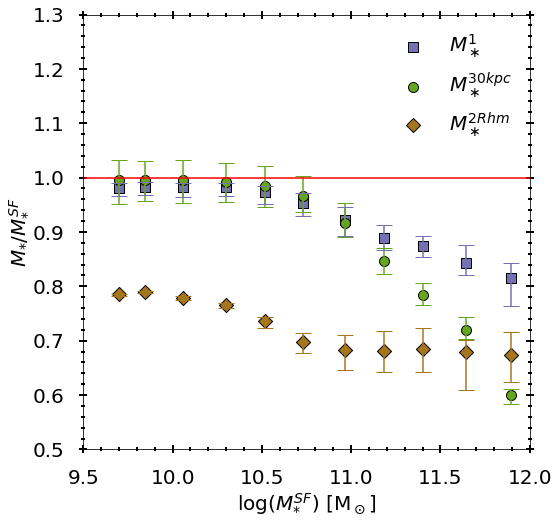

In [9]:
#Draw figure
fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (8,8))
#Plot all data points
old_vals_log = old_log["SubhaloMassStellar"].values
old_vals = old["SubhaloMassStellar"].values
new_vals_1 = new["SubhaloMassStellar"].values
new_vals_2 = new["SubhaloMassStellar30kpc"].values
new_vals_3 = old["SubhaloMassInRadStellar"].values

frac_1 = new_vals_1/old_vals
frac_2 = new_vals_2/old_vals
frac_3 = new_vals_3/old_vals

print(type(frac_1))

x_med1, y_med1, x_err1, y_err1 = il.stats.median_errors(old_vals_log, frac_1, 9.5, 12)
x_med2, y_med2, x_err2, y_err2 = il.stats.median_errors(old_vals_log, frac_2, 9.5, 12)
x_med3, y_med3, x_err3, y_err3 = il.stats.median_errors(old_vals_log, frac_3, 9.5, 12)

#axs.scatter(old_vals_log, frac_2, s=5, alpha=0.8, color="#a6cee3",)
#Plot median values
axs.errorbar(x_med1, y_med1, yerr=y_err1, capsize = 8, color="#7570b3", marker='^', fmt = 'none')
axs.scatter(x_med1, y_med1, marker='s', s=100, color="#7570b3", edgecolors = "black", label = r"$M_\ast^1$")
axs.errorbar(x_med2, y_med2, yerr=y_err3, capsize = 8, color="#66a61e", marker='^', fmt = 'none')
axs.scatter(x_med2, y_med2, marker='o', s=100, color="#66a61e", edgecolors = "black", label = r"$M_\ast^{30kpc}$")
axs.errorbar(x_med3, y_med3, yerr=y_err2, capsize = 8, color="#a6761d", marker='^', fmt = 'none')
axs.scatter(x_med3, y_med3, marker='D', s=100, color="#a6761d", edgecolors = "black", label = r"$M_\ast^{2Rhm}$")



x = np.linspace(0, 12, 2)
y = [1]*2
axs.plot(x, y, c="red")

il.formatplot.SM_fSM(ax=axs, y0 = 0.5, y1 = 1.3)
plt.savefig("../fig/SM_fSM.png", dpi=300, bbox_inches='tight')

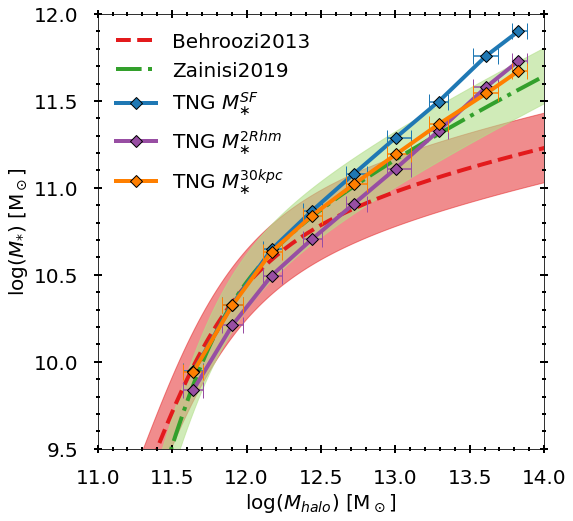

In [10]:
#Create the plot
fig, ax = plt.subplots(figsize = (8,8))

#Behroozi 2013
B2013x, B2013y = behroozi(a=-1.412, M1=10**(11.514), c=0.316, d=3.508, e=10**(-1.777))
#converting to same cosmology
B2013x = B2013x*h_b/h_tng
B2013y = B2013y*h_b**2/h_tng**2
#Adding maximum error in log format
B_err_lower = np.log10(B2013y) - 0.2
B_err_upper = np.log10(B2013y) + 0.2
ax.plot(np.log10(B2013x), np.log10(B2013y), "--", c="#e31a1c", linewidth=4, label= "Behroozi2013")
ax.fill_between(np.log10(B2013x), B_err_lower, B_err_upper, alpha=0.5, color="#e31a1c")

#Zainisi 2019
Z2019x, Z2019y = behroozi(a=-2.352, M1=10**(11.632), c = 0.600, d=3.797, e=10**(-1.785))
#converting to same cosmology
Z2019x = Z2019x*h_z/h_tng
Z2019y = Z2019y*h_z**2/h_tng**2
#Adding maximum error in log format
#Z_errors = il.stats.error_estimate_behroozi(a=-2.352, M1=10**(11.632), c = 0.600, d=3.797, e=10**(-1.785), delta_a=0.026, delta_M1=0.008, delta_c=0.1, delta_d=0.052, delta_e=0.01, x=Z2019x)
Z_err_lower = np.log10(Z2019y) - 0.16 #Z_errors
Z_err_upper = np.log10(Z2019y) + 0.16 #Z_errors
ax.plot(np.log10(Z2019x), np.log10(Z2019y), "-.", c="#33a02c", linewidth=4, label= "Zainisi2019")
ax.fill_between(np.log10(Z2019x), Z_err_lower, Z_err_upper, alpha=0.6, color="#b2df8a")

#Calculate mean values TNG
SF_x = old_log["SubhaloMass"].values
SF_y = old_log["SubhaloMassStellar"].values
mSF_x, mSF_y, eSF_x, eSF_y = il.stats.median_errors(SF_x, SF_y, 11.5, 14, 10)
#eSF_x, eSF_y = il.stats.log_errors(eSF_x, eSF_y, mSF_x, mSF_y)
ax.errorbar(mSF_x, mSF_y, xerr=eSF_x, capsize = 8, color="#1f78b4", marker='^', fmt = 'none')
ax.plot(mSF_x, mSF_y, marker='D', linewidth=4, markersize=8, c="#1f78b4", markeredgecolor = "black", label = r"TNG $M_{\ast}^{SF}$")

#Calculate mean values TNG
SF2_x = old_log["SubhaloMass"].values
SF2_y = old_log["SubhaloMassInRadStellar"].values
mSF2_x, mSF2_y, eSF2_x, eSF2_y = il.stats.median_errors(SF2_x, SF2_y, 11.5, 14, 10)
#eSF_x, eSF_y = il.stats.log_errors(eSF_x, eSF_y, mSF_x, mSF_y)
ax.errorbar(mSF2_x, mSF2_y, xerr=eSF2_x, capsize = 8, color="#984ea3", marker='^', fmt = 'none')
ax.plot(mSF2_x, mSF2_y, marker='D', linewidth=4, markersize=8, c="#984ea3", markeredgecolor = "black", label = r"TNG $M_{\ast}^{2Rhm}$")

#Calculate mean values TNG
TNG_x = old_log["SubhaloMass"].values
TNG_y = new_log["SubhaloMassStellar30kpc"].values
mTNG_x, mTNG_y, eTNG_x, eTNG_y = il.stats.median_errors(TNG_x, TNG_y, 11.5, 14, 10)
#eTNG_x, eTNG_y = il.stats.log_errors(eTNG_x, eTNG_y, mTNG_x, mTNG_y)
ax.errorbar(mTNG_x, mTNG_y, xerr=eTNG_x, capsize = 8, color="#ff7f00", marker='^', fmt = 'none')
ax.plot(mTNG_x, mTNG_y, marker='D', linewidth=4, markersize=8, c="#ff7f00", markeredgecolor = "black", label = r"TNG $M_{\ast}^{30kpc}$")


il.formatplot.HM_SM(ax=ax, y0=9.5, y1=12, x0=11, x1=14)
plt.savefig("../fig/shmr.png", dpi=300, bbox_inches='tight')

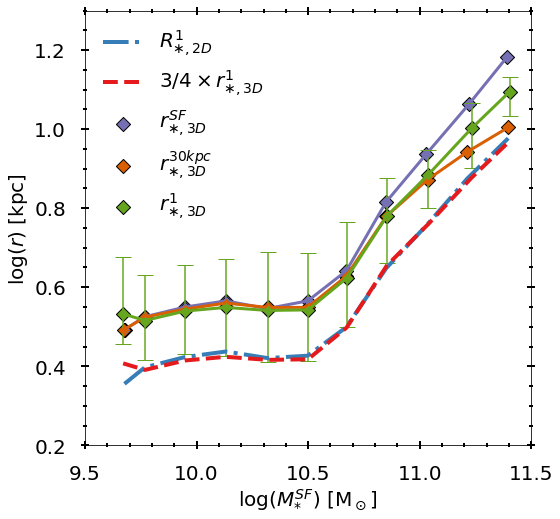

In [11]:
#Draw figure
fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (8,8))
#Plot all data points
x_vals = old_log["SubhaloMassStellar"].values
x_vals_2 = new_log["SubhaloMassStellar30kpc"].values
x_vals_1 = new_log["SubhaloMassStellar"].values
old_vals = old_log["SubhaloHalfmassRadStellar"].values
new_vals_1 = new_log["SubhaloHalfmassRadStellar"].values
new_vals_2 = new_log["SubhaloHalfmassRadStellar30kpc"].values
new_vals_3 = new_log["SubhaloHalfmassRadProj"].values
#old_vals_2 = (3/4)*old_log["SubhaloHalfmassRadStellar"].values
new_vals_4 = (np.log10(3/4)+new_log["SubhaloHalfmassRadStellar"]).values


#new_vals_3 = old["SubhaloMassInRadStellar"].values

x_med1, y_med1, x_err1, y_err1 = il.stats.median_errors(x_vals, old_vals, 9.5, 11.5)
x_med2, y_med2, x_err2, y_err2 = il.stats.median_errors(x_vals_1, new_vals_1, 9.5, 11.5)
x_med3, y_med3, x_err3, y_err3 = il.stats.median_errors(x_vals_2, new_vals_2, 9.5, 11.5)
x_med4, y_med4, x_err4, y_err4 = il.stats.median_errors(x_vals_2, new_vals_3, 9.5, 11.5)
x_med5, y_med5, x_err5, y_err5 = il.stats.median_errors(x_vals_1, new_vals_4, 9.5, 11.5)

#axs.scatter(x_vals_log, new_vals_1, s=5, alpha=0.8, color="#a6cee3",)
#Plot median values

#axs.errorbar(x_med1, y_med1, yerr=y_err1, capsize = 8, color="#7570b3", marker='^', fmt = 'none')
axs.scatter(x_med1, y_med1, marker='D', s=100, color="#7570b3", edgecolors = "black", label = r"$r^{SF}_{\ast, 3D}$")
axs.plot(x_med1, y_med1, marker='D', linewidth=3, color="#7570b3")

#axs.errorbar(x_med3, y_med3, yerr=y_err3, capsize = 8, color="#a6761d", marker='^', fmt = 'none')
axs.scatter(x_med3, y_med3, marker='D', s=100, color="#d95f02", edgecolors = "black", label = r"$r^{30kpc}_{\ast, 3D}$")
axs.plot(x_med3, y_med3, marker='D', linewidth=3, color="#d95f02")

axs.errorbar(x_med2, y_med2, yerr=y_err2, capsize = 8, color="#66a61e", marker='^', fmt = 'none')
axs.scatter(x_med2, y_med2, marker='D', s=100, color="#66a61e", edgecolors = "black", label = r"$r^{1}_{\ast, 3D}$")
axs.plot(x_med2, y_med2, marker='D', linewidth=3, color="#66a61e")

axs.plot(x_med4, y_med4, "-.", linewidth=4, color="#377eb8", label = r"$R^{1}_{\ast, 2D}$")

axs.plot(x_med5, y_med5, "--", linewidth=4, color="#e41a1c", label = r"$3/4 \times r^{1}_{\ast, 3D}$")

il.formatplot.SM_R(ax=axs, x0= 9.5, x1= 11.5, y0=0.2, y1=1.3)
axs.set_xlabel(r"$\log(M_{*}^{SF})$ [$ \mathrm{M}_\odot $]", fontsize=20)
plt.savefig("../fig/SM_R_tng.png", dpi=300, bbox_inches='tight')

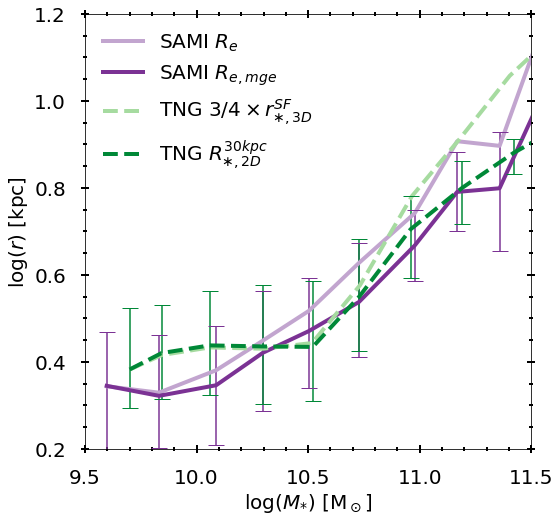

In [12]:
#Draw figure
fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (8,8))
#Plot all data points

x_med2, y_med2, x_err2, y_err2 = il.stats.median_values_df(sami_log, "sami", "mstar", "r_e_circ", xmin=9.5, xmax=12, n=12, error_out=True)
x_med3, y_med3, x_err3, y_err3 = il.stats.median_values_df(sami_log, "sami", "mstar", "r_mge", xmin=9.5, xmax=12, n=12, error_out=True)

x_vals_old = old_log["SubhaloMassStellar"].values
x_vals_new = new_log["SubhaloMassStellar30kpc"].values
new_vals_4 = new_log["SubhaloHalfmassRadProj30kpc"].values
old_vals = (old_log["SubhaloHalfmassRadStellar"] + np.log10(3/4)).values

x_med4, y_med4, x_err4, y_err4 = il.stats.median_errors(x_vals_new, new_vals_4, 9.5, 12)
x_med5, y_med5, x_err5, y_err5 = il.stats.median_errors(x_vals_old, old_vals, 9.5, 12)

#axs.errorbar(x_med2, y_med2, yerr=y_err2, capsize = 8, color="#7570b3", marker='^', fmt = 'none')
#axs.scatter(x_med2, y_med2, marker='D', s=100, color="#7570b3", edgecolors = "black", label = r"r_e_circ")
axs.plot(x_med2, y_med2, linewidth=4, color="#c2a5cf", label = r"SAMI $R_{e}$")

axs.errorbar(x_med3, y_med3, yerr=y_err3, capsize = 8, color="#7b3294", marker='^', fmt = 'none')
#axs.scatter(x_med3, y_med3, marker='D', s=100, color="#66a61e", edgecolors = "black", label = r"r_mge")
axs.plot(x_med3, y_med3, linewidth=4, color="#7b3294", label = r"SAMI $R_{e, mge}$")

#axs.errorbar(x_med5, y_med5, yerr=y_err5, capsize = 8, color="#66a61e", marker='^', fmt = 'none')
#axs.scatter(x_med5, y_med5, marker='D', s=100, color="grey", edgecolors = "black", label = r"TNG r^{SF}_{hm}")
axs.plot(x_med5, y_med5, "--", linewidth=4, color="#a6dba0", label = r"TNG $3/4 \times r^{SF}_{\ast, 3D}$")

axs.errorbar(x_med4, y_med4, yerr=y_err4, capsize = 8, color="#008837", marker='^', fmt = 'none')
#axs.scatter(x_med4, y_med4, marker='D', s=100, color="red", edgecolors = "black", label = r"TNG r_30kpc")
axs.plot(x_med4, y_med4, "--", linewidth=4, color="#008837", label = r"TNG $R^{30kpc}_{\ast, 2D}$")


il.formatplot.SM_R(ax=axs, x0= 9.5, x1= 11.5, y0=0.2, y1=1.2)
plt.savefig("../fig/SM_R.png", dpi=300, bbox_inches='tight')

C:\Users\auror\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\auror\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


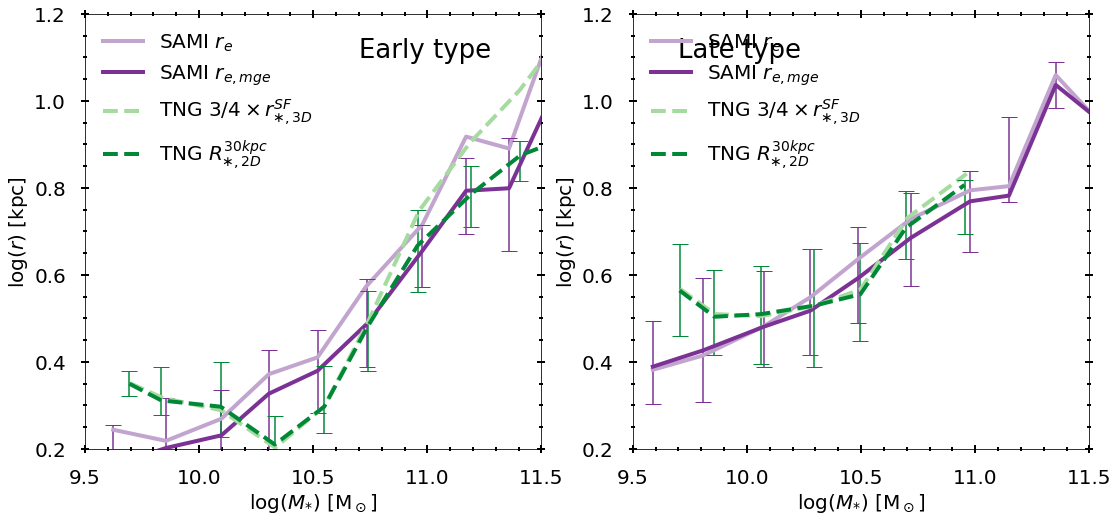

In [13]:
#Draw figure
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (18,8))

#Early type
x_med1_earlies, y_med1_earlies, x_err1_earlies, y_err1_earlies = il.stats.median_values_df(sami_earlies_log, "sami", "mstar", "r_e_circ", xmin=9.5, xmax=12, n=12, error_out=True)
x_med2_earlies, y_med2_earlies, x_err2_earlies, y_err2_earlies = il.stats.median_values_df(sami_earlies_log, "sami", "mstar", "r_mge", xmin=9.5, xmax=12, n=12, error_out=True)

x_vals_3_earlies = new_earlies_log["SubhaloMassStellar30kpc"].values
x_vals_4_earlies = old_earlies_log["SubhaloMassStellar"].values
y_vals_3_earlies = new_earlies_log["SubhaloHalfmassRadProj30kpc"].values
y_vals_4_earlies = (old_earlies_log["SubhaloHalfmassRadStellar"] + np.log10(3/4)).values

x_med3_earlies, y_med3_earlies, x_err3_earlies, y_err3_earlies = il.stats.median_errors(x_vals_3_earlies, y_vals_3_earlies, 9.5, 12)
x_med4_earlies, y_med4_earlies, x_err4_earlies, y_err4_earlies = il.stats.median_errors(x_vals_4_earlies, y_vals_4_earlies, 9.5, 12)

#plot
axs[0].plot(x_med1_earlies, y_med1_earlies, linewidth=4, color="#c2a5cf", label = r"SAMI $r_{e}$")
axs[0].errorbar(x_med2_earlies, y_med2_earlies, yerr=y_err2_earlies, capsize = 8, color="#7b3294", marker='^', fmt = 'none')
axs[0].plot(x_med2_earlies, y_med2_earlies, linewidth=4, color="#7b3294", label = r"SAMI $r_{e, mge}$")
axs[0].plot(x_med4_earlies, y_med4_earlies, "--", linewidth=4, color="#a6dba0", label = r"TNG $3/4 \times r^{SF}_{\ast, 3D}$")
axs[0].errorbar(x_med3_earlies, y_med3_earlies, yerr=y_err3_earlies, capsize = 8, color="#008837", marker='^', fmt = 'none')
axs[0].plot(x_med3_earlies, y_med3_earlies, "--", linewidth=4, color="#008837", label = r"TNG $R^{30kpc}_{\ast, 2D}$")
#Format
il.formatplot.SM_R(axs[0], x0= 9.5, x1= 11.5, y0=0.2, y1=1.2)
axs[0].text(10.7, 1.1, "Early type", fontsize=26)

#Late type
x_med1_lates, y_med1_lates, x_err1_lates, y_err1_lates = il.stats.median_values_df(sami_lates_log, "sami", "mstar", "r_e_circ", xmin=9.5, xmax=12, n=12, error_out=True)
x_med2_lates, y_med2_lates, x_err2_lates, y_err2_lates = il.stats.median_values_df(sami_lates_log, "sami", "mstar", "r_mge", xmin=9.5, xmax=12, n=12, error_out=True)

x_vals_3_lates = new_lates_log["SubhaloMassStellar30kpc"].values
x_vals_4_lates = old_lates_log["SubhaloMassStellar"].values
y_vals_3_lates = new_lates_log["SubhaloHalfmassRadProj30kpc"].values
y_vals_4_lates = (old_lates_log["SubhaloHalfmassRadStellar"] + np.log10(3/4)).values

x_med3_lates, y_med3_lates, x_err3_lates, y_err3_lates = il.stats.median_errors(x_vals_3_lates, y_vals_3_lates, 9.5, 12)
x_med4_lates, y_med4_lates, x_err4_lates, y_err4_lates = il.stats.median_errors(x_vals_4_lates, y_vals_4_lates, 9.5, 12)

#plot
axs[1].plot(x_med1_lates, y_med1_lates, linewidth=4, color="#c2a5cf", label = r"SAMI $r_{e}$")
axs[1].errorbar(x_med2_lates, y_med2_lates, yerr=y_err2_lates, capsize = 8, color="#7b3294", marker='^', fmt = 'none')
axs[1].plot(x_med2_lates, y_med2_lates, linewidth=4, color="#7b3294", label = r"SAMI $r_{e, mge}$")
axs[1].plot(x_med4_lates, y_med4_lates, "--", linewidth=4, color="#a6dba0", label = r"TNG $3/4 \times r^{SF}_{\ast, 3D}$")
axs[1].errorbar(x_med3_lates, y_med3_lates, yerr=y_err3_lates, capsize = 8, color="#008837", marker='^', fmt = 'none')
axs[1].plot(x_med3_lates, y_med3_lates, "--", linewidth=4, color="#008837", label = r"TNG $R^{30kpc}_{\ast, 2D}$")
#Format
il.formatplot.SM_R(axs[1], x0= 9.5, x1= 11.5, y0=0.2, y1=1.2)
axs[1].text(9.7, 1.1, "Late type", fontsize=26)
plt.savefig("../fig/SM_R_morph.png", dpi=300, bbox_inches='tight')


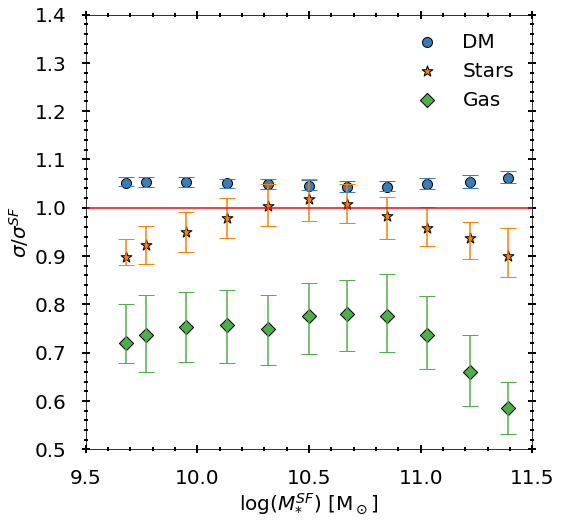

In [14]:
#Draw figure
fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (8,8))
#Plot all data points
old_vals_log = old_log["SubhaloMassStellar"].values
old_vals = old["SubhaloVelDisp"].values
new_vals_1 = new["SubhaloVelDispTotalStellar1D"].values
new_vals_2 = new["SubhaloVelDispTotalGas1D"].values
new_vals_3 = new["SubhaloVelDispTotalDM1D"].values

frac_1 = new_vals_1/old_vals
frac_2 = new_vals_2/old_vals
frac_3 = new_vals_3/old_vals

x_med1, y_med1, x_err1, y_err1 = il.stats.median_errors(old_vals_log, frac_1, 9.5, 11.5)
x_med2, y_med2, x_err2, y_err2 = il.stats.median_errors(old_vals_log, frac_2, 9.5, 11.5)
x_med3, y_med3, x_err3, y_err3 = il.stats.median_errors(old_vals_log, frac_3, 9.5, 11.5)

#axs.scatter(old_vals_log, frac_2, s=5, alpha=0.8, color="#a6cee3",)
#Plot median values

axs.errorbar(x_med3, y_med3, yerr=y_err3, capsize = 8, color="#377eb8", marker='^', fmt = 'none')
axs.scatter(x_med3, y_med3, marker='o', s=100, color="#377eb8", edgecolors = "black", label = r"DM")

axs.errorbar(x_med1, y_med1, yerr=y_err1, capsize = 8, color="#ff7f00", marker='^', fmt = 'none')
axs.scatter(x_med1, y_med1, marker='*', s=130, color="#ff7f00", edgecolors = "black", label = r"Stars")

axs.errorbar(x_med2, y_med2, yerr=y_err2, capsize = 8, color="#4daf4a", marker='^', fmt = 'none')
axs.scatter(x_med2, y_med2, marker='D', s=100, color="#4daf4a", edgecolors = "black", label = r"Gas")

x = np.linspace(0, 12, 2)
y = [1]*2
axs.plot(x, y, c="red")

il.formatplot.SM_fVD(ax=axs, y0 = 0.5, y1 = 1.4, x1=11.5)
plt.savefig("../fig/VD_particles.png", dpi=300, bbox_inches='tight')

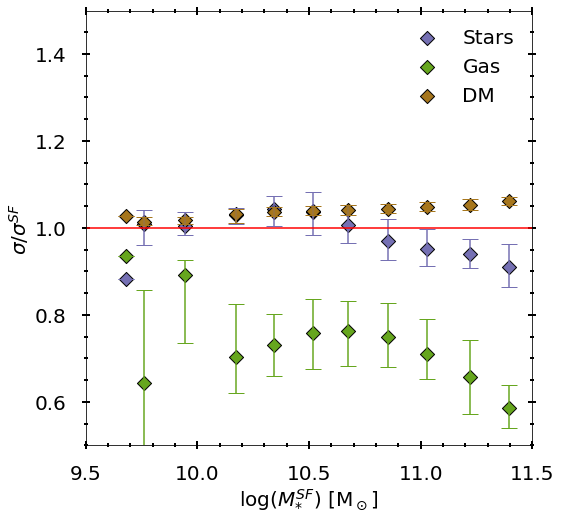

In [15]:
#Draw figure
fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (8,8))
#Plot all data points
old_vals_log = old_earlies_log["SubhaloMassStellar"].values
old_vals = old_earlies["SubhaloVelDisp"].values
new_vals_1 = new_earlies["SubhaloVelDispTotalStellar1D"].values
new_vals_2 = new_earlies["SubhaloVelDispTotalGas1D"].values
new_vals_3 = new_earlies["SubhaloVelDispTotalDM1D"].values

frac_1 = new_vals_1/old_vals
frac_2 = new_vals_2/old_vals
frac_3 = new_vals_3/old_vals

x_med1, y_med1, x_err1, y_err1 = il.stats.median_errors(old_vals_log, frac_1, 9.5, 11.5)
x_med2, y_med2, x_err2, y_err2 = il.stats.median_errors(old_vals_log, frac_2, 9.5, 11.5)
x_med3, y_med3, x_err3, y_err3 = il.stats.median_errors(old_vals_log, frac_3, 9.5, 11.5)

#axs.scatter(old_vals_log, frac, s=5, alpha=0.8, color="#a6cee3",)
#Plot median values
axs.errorbar(x_med1, y_med1, yerr=y_err1, capsize = 8, color="#7570b3", marker='^', fmt = 'none')
axs.scatter(x_med1, y_med1, marker='D', s=100, color="#7570b3", edgecolors = "black", label = r"Stars")

axs.errorbar(x_med2, y_med2, yerr=y_err2, capsize = 8, color="#66a61e", marker='^', fmt = 'none')
axs.scatter(x_med2, y_med2, marker='D', s=100, color="#66a61e", edgecolors = "black", label = r"Gas")

axs.errorbar(x_med3, y_med3, yerr=y_err3, capsize = 8, color="#a6761d", marker='^', fmt = 'none')
axs.scatter(x_med3, y_med3, marker='D', s=100, color="#a6761d", edgecolors = "black", label = r"DM")


x = np.linspace(0, 12, 2)
y = [1]*2
axs.plot(x, y, c="red")

il.formatplot.SM_fVD(ax=axs, y0 = 0.5, y1 = 1.5, x1=11.5)
plt.savefig("../fig/SM_fVD.png", dpi=300, bbox_inches='tight')

C:\Users\auror\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\auror\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


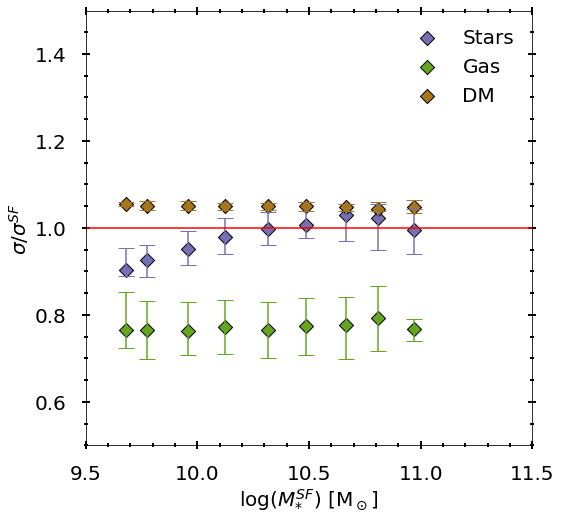

In [16]:
#Draw figure
fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (8,8))
#Plot all data points
old_vals_log = old_lates_log["SubhaloMassStellar"].values
old_vals = old_lates["SubhaloVelDisp"].values
new_vals_1 = new_lates["SubhaloVelDispTotalStellar1D"].values
new_vals_2 = new_lates["SubhaloVelDispTotalGas1D"].values
new_vals_3 = new_lates["SubhaloVelDispTotalDM1D"].values

frac_1 = new_vals_1/old_vals
frac_2 = new_vals_2/old_vals
frac_3 = new_vals_3/old_vals

x_med1, y_med1, x_err1, y_err1 = il.stats.median_errors(old_vals_log, frac_1, 9.5, 11.5)
x_med2, y_med2, x_err2, y_err2 = il.stats.median_errors(old_vals_log, frac_2, 9.5, 11.5)
x_med3, y_med3, x_err3, y_err3 = il.stats.median_errors(old_vals_log, frac_3, 9.5, 11.5)

#axs.scatter(old_vals_log, frac, s=5, alpha=0.8, color="#a6cee3",)
#Plot median values
axs.errorbar(x_med1, y_med1, yerr=y_err1, capsize = 8, color="#7570b3", marker='^', fmt = 'none')
axs.scatter(x_med1, y_med1, marker='D', s=100, color="#7570b3", edgecolors = "black", label = r"Stars")

axs.errorbar(x_med2, y_med2, yerr=y_err2, capsize = 8, color="#66a61e", marker='^', fmt = 'none')
axs.scatter(x_med2, y_med2, marker='D', s=100, color="#66a61e", edgecolors = "black", label = r"Gas")

axs.errorbar(x_med3, y_med3, yerr=y_err3, capsize = 8, color="#a6761d", marker='^', fmt = 'none')
axs.scatter(x_med3, y_med3, marker='D', s=100, color="#a6761d", edgecolors = "black", label = r"DM")


x = np.linspace(0, 12, 2)
y = [1]*2
axs.plot(x, y, c="red")

il.formatplot.SM_fVD(ax=axs, y0 = 0.5, y1 = 1.5, x1=11.5)
plt.savefig("../fig/SM_fVD.png", dpi=300, bbox_inches='tight')

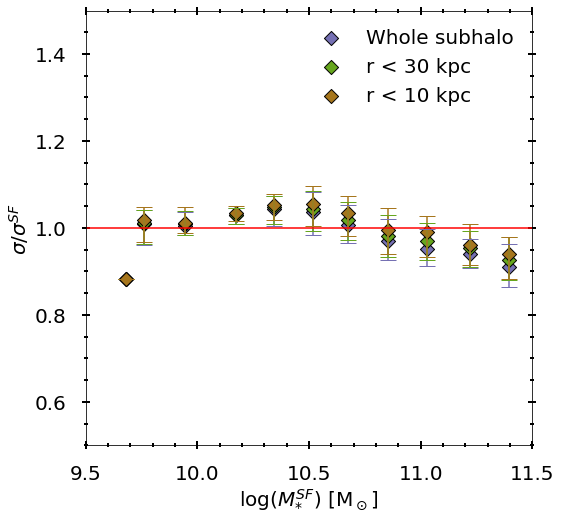

In [17]:
#Draw figure
fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (8,8))
#Plot all data points
old_vals_log = old_earlies_log["SubhaloMassStellar"].values
old_vals = old_earlies["SubhaloVelDisp"].values
new_vals_1 = new_earlies["SubhaloVelDispTotalStellar1D"].values
new_vals_2 = new_earlies["SubhaloVelDisp1D_Stellar_30kpc"].values
new_vals_3 = new_earlies["SubhaloVelDisp1D_Stellar_10kpc"].values

frac_1 = new_vals_1/old_vals
frac_2 = new_vals_2/old_vals
frac_3 = new_vals_3/old_vals

x_med1, y_med1, x_err1, y_err1 = il.stats.median_errors(old_vals_log, frac_1, 9.5, 11.5)
x_med2, y_med2, x_err2, y_err2 = il.stats.median_errors(old_vals_log, frac_2, 9.5, 11.5)
x_med3, y_med3, x_err3, y_err3 = il.stats.median_errors(old_vals_log, frac_3, 9.5, 11.5)

#axs.scatter(old_vals_log, frac, s=5, alpha=0.8, color="#a6cee3",)
#Plot median values
axs.errorbar(x_med1, y_med1, yerr=y_err1, capsize = 8, color="#7570b3", marker='^', fmt = 'none')
axs.scatter(x_med1, y_med1, marker='D', s=100, color="#7570b3", edgecolors = "black", label = r"Whole subhalo")

axs.errorbar(x_med2, y_med2, yerr=y_err2, capsize = 8, color="#66a61e", marker='^', fmt = 'none')
axs.scatter(x_med2, y_med2, marker='D', s=100, color="#66a61e", edgecolors = "black", label = r"r < 30 kpc")

axs.errorbar(x_med3, y_med3, yerr=y_err3, capsize = 8, color="#a6761d", marker='^', fmt = 'none')
axs.scatter(x_med3, y_med3, marker='D', s=100, color="#a6761d", edgecolors = "black", label = r"r < 10 kpc")


x = np.linspace(0, 12, 2)
y = [1]*2
axs.plot(x, y, c="red")

il.formatplot.SM_fVD(ax=axs, y0 = 0.5, y1 = 1.5, x1=11.5)
plt.savefig("../fig/SM_fVD.png", dpi=300, bbox_inches='tight')

C:\Users\auror\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\auror\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


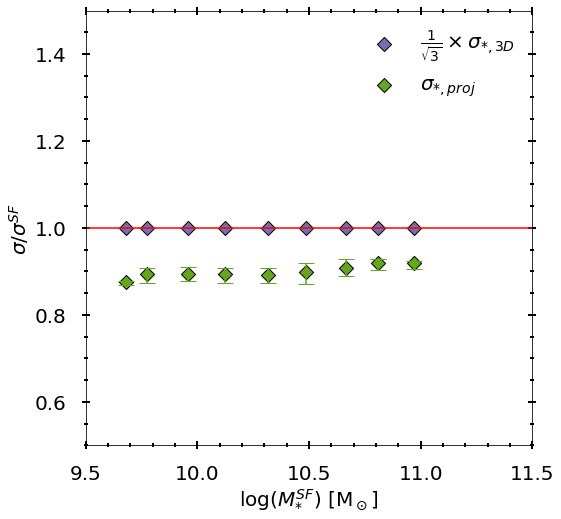

In [18]:
#Draw figure
fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (8,8))
#Plot all data points
old_vals_log = old_lates_log["SubhaloMassStellar"].values
old_vals = new_lates["SubhaloVelDispTotalStellar1D"].values
new_vals_1 = new_lates["SubhaloVelDispTotalStellar1D"].values
new_vals_2 = new_lates["SubhaloVelDispTotalStellar"].values
#new_vals_3 = new["SubhaloVelDispTotalDM1D"].values

frac_1 = new_vals_1/old_vals
frac_2 = new_vals_2/old_vals
#frac_3 = new_vals_3/old_vals

x_med1, y_med1, x_err1, y_err1 = il.stats.median_errors(old_vals_log, frac_1, 9.5, 11.5)
x_med2, y_med2, x_err2, y_err2 = il.stats.median_errors(old_vals_log, frac_2, 9.5, 11.5)
#x_med3, y_med3, x_err3, y_err3 = il.stats.median_errors(old_vals_log, frac_3, 9.5, 11.5)

#axs.scatter(old_vals_log, frac_2, s=5, alpha=0.8, color="#a6cee3",)
#Plot median values
axs.errorbar(x_med1, y_med1, yerr=y_err1, capsize = 8, color="#7570b3", marker='^', fmt = 'none')
axs.scatter(x_med1, y_med1, marker='D', s=100, color="#7570b3", edgecolors = "black", label = r"$\frac{1}{\sqrt{3}} \times \sigma_{*, 3D}$")

axs.errorbar(x_med2, y_med2, yerr=y_err2, capsize = 8, color="#66a61e", marker='^', fmt = 'none')
axs.scatter(x_med2, y_med2, marker='D', s=100, color="#66a61e", edgecolors = "black", label = r"$\sigma_{*, proj}$")

#axs.errorbar(x_med3, y_med3, yerr=y_err3, capsize = 8, color="#a6761d", marker='^', fmt = 'none')
#axs.scatter(x_med3, y_med3, marker='D', s=100, color="#a6761d", edgecolors = "black", label = r"DM")


x = np.linspace(0, 12, 2)
y = [1]*2
axs.plot(x, y, c="red")

il.formatplot.SM_fVD(ax=axs, y0 = 0.5, y1 = 1.5, x1=11.5)

C:\Users\auror\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\auror\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


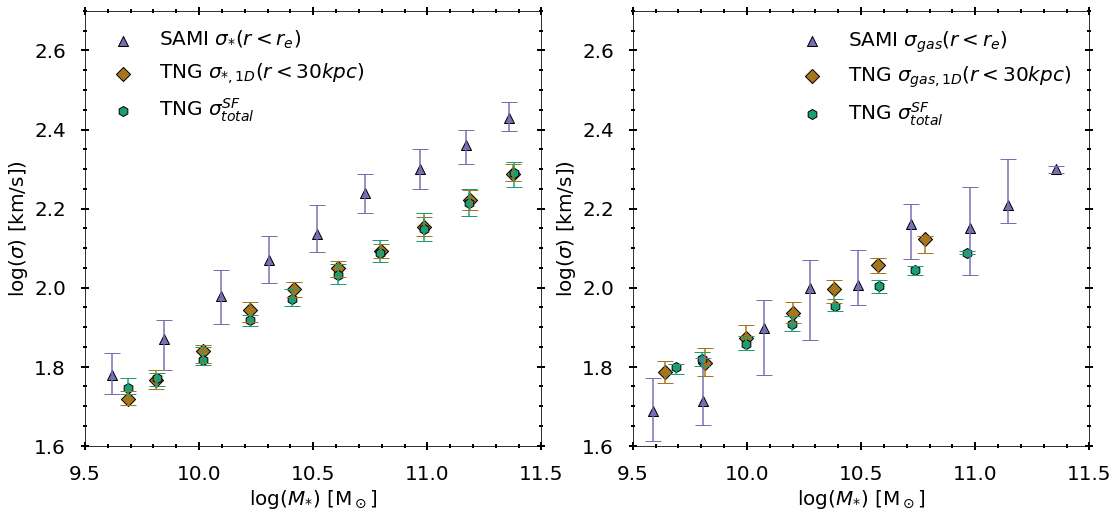

In [19]:
#Draw figure
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (18,8))
#Plot all data points

#Stellar particles
x_med1, y_med1, x_err1, y_err1 = il.stats.median_values_df(sami_earlies_log, "sami", "mstar", "sigma_re", xmin=9.5, xmax=12, n=12, error_out=True)

x_vals_2 = new_earlies_log["SubhaloMassStellar30kpc"].values
x_vals_3 = old_earlies_log["SubhaloMassStellar"].values
new_vals_2 = new_earlies_log["SubhaloVelDisp1D_Stellar_30kpc"].values
new_vals_3 = old_earlies_log["SubhaloVelDisp"].values

x_med2, y_med2, x_err2, y_err2 = il.stats.median_errors(x_vals_2, new_vals_2, 9.5, 11.5, n=11)
x_med3, y_med3, x_err3, y_err3 = il.stats.median_errors(x_vals_3, new_vals_3, 9.5, 11.5, n=11)

#sami_earlies_log.plot.scatter(x="mstar", y = "sigma_re",s=20, label="SAMI", alpha=0.5, color="#7570b3", ax = axs)
#Plot median values
axs[0].errorbar(x_med1, y_med1, yerr=y_err1, capsize = 8, color="#7570b3", marker='^', fmt = 'none')
axs[0].scatter(x_med1, y_med1, marker='^', s=100, color="#7570b3", edgecolors = "black", label = r"SAMI $\sigma_{*}(r < r_{e})$")

axs[0].errorbar(x_med2, y_med2, yerr=y_err2, capsize = 8, color="#a6761d", marker='^', fmt = 'none')
axs[0].scatter(x_med2, y_med2, marker='D', s=100, color="#a6761d", edgecolors = "black", label = r"TNG $\sigma_{*, 1D}(r < 30 kpc)$")

axs[0].errorbar(x_med3, y_med3, yerr=y_err3, capsize = 8, color="#1b9e77", marker='^', fmt = 'none')
axs[0].scatter(x_med3, y_med3, marker='h', s=100, color="#1b9e77", edgecolors = "black", label = r"TNG $\sigma^{SF}_{total}$")
il.formatplot.SM_VD(ax=axs[0], x0 = 9.5, x1=11.5, y0 = 1.6, y1 = 2.7)

#gas
x_med1, y_med1, x_err1, y_err1 = il.stats.median_values_df(sami_lates_log, "sami", "mstar", "vdisp_gas_re", xmin=9.5, xmax=12, n=12, error_out=True)
x_vals_2 = new_lates_log["SubhaloMassInRad30kpcStellar"].values
x_vals_3 = old_lates_log["SubhaloMassStellar"].values
new_vals_2 = new_lates_log["SubhaloVelDisp1D_Gas_30kpc"].values
new_vals_3 = old_lates_log["SubhaloVelDisp"].values

x_med2, y_med2, x_err2, y_err2 = il.stats.median_errors(x_vals_2, new_vals_2, 9.5, 11.5, n=11)
x_med3, y_med3, x_err3, y_err3 = il.stats.median_errors(x_vals_3, new_vals_3, 9.5, 11.5, n=11)

#sami_earlies_log.plot.scatter(x="mstar", y = "sigma_re",s=20, label="SAMI", alpha=0.5, color="#7570b3", ax = axs)
#Plot median values
axs[1].errorbar(x_med1, y_med1, yerr=y_err1, capsize = 8, color="#7570b3", marker='^', fmt = 'none')
axs[1].scatter(x_med1, y_med1, marker='^', s=100, color="#7570b3", edgecolors = "black", label = r"SAMI $\sigma_{gas}(r < r_{e})$")

axs[1].errorbar(x_med2, y_med2, yerr=y_err2, capsize = 8, color="#a6761d", marker='^', fmt = 'none')
axs[1].scatter(x_med2, y_med2, marker='D', s=100, color="#a6761d", edgecolors = "black", label = r"TNG $\sigma_{gas, 1D}(r < 30 kpc)$")

axs[1].errorbar(x_med3, y_med3, yerr=y_err3, capsize = 8, color="#1b9e77", marker='^', fmt = 'none')
axs[1].scatter(x_med3, y_med3, marker='h', s=100, color="#1b9e77", edgecolors = "black", label = r"TNG $\sigma^{SF}_{total}$")
il.formatplot.SM_VD(ax=axs[1], x0 = 9.5, x1=11.5, y0 = 1.6, y1 = 2.7)

plt.savefig("../fig/SM_sigma.png", dpi=300, bbox_inches='tight')

slope: [[0.37392164]]
intercept: [-1.80513967]
R^2: 0.9955021791383281
slope: [[0.31706554]]
intercept: [-1.31808581]
R^2: 0.9296557737908725


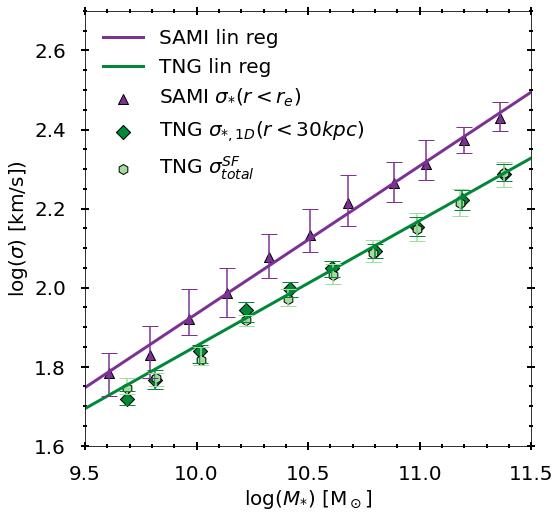

In [20]:
#Draw figure
fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (8,8))
#Plot all data points

#Stellar particles
x_med1, y_med1, x_err1, y_err1 = il.stats.median_values_df(sami_earlies_log, "sami", "mstar", "sigma_re", xmin=9.5, xmax=11.5, n=12, error_out=True)

x_vals_2 = new_earlies_log["SubhaloMassStellar30kpc"].values
x_vals_3 = old_earlies_log["SubhaloMassStellar"].values
new_vals_2 = new_earlies_log["SubhaloVelDisp1D_Stellar_30kpc"].values
new_vals_3 = old_earlies_log["SubhaloVelDisp"].values

x_med2, y_med2, x_err2, y_err2 = il.stats.median_errors(x_vals_2, new_vals_2, 9.5, 11.5, n=11)
x_med3, y_med3, x_err3, y_err3 = il.stats.median_errors(x_vals_3, new_vals_3, 9.5, 11.5, n=11)

#print(x_med1, y_med1)
#Linear regression
regX_S1, regY_S1 = il.stats.lin_reg(x_med1, y_med1, xmin=9.5, xmax=12)
axs.plot(regX_S1, regY_S1, linewidth = 3, label ="SAMI lin reg", color="#7b3294")

regX_TNG1, regY_TNG1 = il.stats.lin_reg(x_vals_2, new_vals_2, xmin=9.5, xmax=12)
axs.plot(regX_TNG1, regY_TNG1, linewidth = 3, label ="TNG lin reg", color="#008837")

#Plot median values
axs.errorbar(x_med1, y_med1, yerr=y_err1, capsize = 8, color="#7b3294", marker='^', fmt = 'none')
axs.scatter(x_med1, y_med1, marker='^', s=100, color="#7b3294", edgecolors = "black", label = r"SAMI $\sigma_{*}(r < r_{e})$")

axs.errorbar(x_med2, y_med2, yerr=y_err2, capsize = 8, color="#008837", marker='^', fmt = 'none')
axs.scatter(x_med2, y_med2, marker='D', s=100, color="#008837", edgecolors = "black", label = r"TNG $\sigma_{*, 1D}(r < 30 kpc)$")

axs.errorbar(x_med3, y_med3, yerr=y_err3, capsize = 8, color="#a6dba0", marker='^', fmt = 'none')
axs.scatter(x_med3, y_med3, marker='h', s=100, color="#a6dba0", edgecolors = "black", label = r"TNG $\sigma^{SF}_{total}$")
il.formatplot.SM_VD(ax=axs, x0 = 9.5, x1=11.5, y0 = 1.6, y1 = 2.7)

plt.savefig("../fig/FJ.png", dpi=300, bbox_inches='tight')

C:\Users\auror\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\auror\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


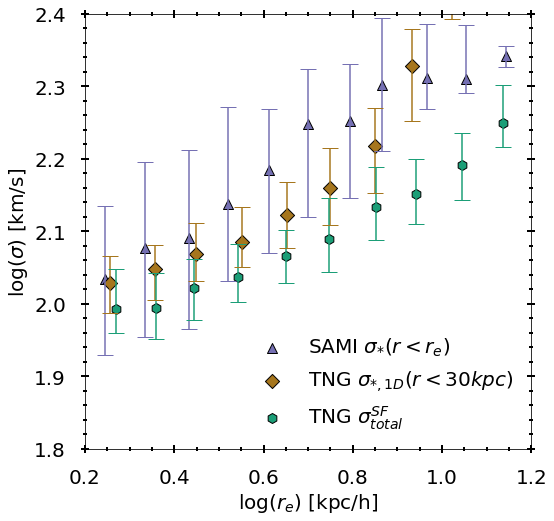

In [21]:
#Draw figure
fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (8,8))
#Plot all data points

#Stellar particles
x_med1, y_med1, x_err1, y_err1 = il.stats.median_values_df(sami_earlies_log, "sami", "r_e_circ", "sigma_re", xmin=0.2, xmax=1.2, n=12, error_out=True)

x_vals_2 = new_earlies_log["SubhaloHalfmassRadProj30kpc"].values
x_vals_3 = old_earlies_log["SubhaloHalfmassRadStellar"].values
new_vals_2 = new_earlies_log["SubhaloVelDisp1D_Stellar_30kpc"].values
new_vals_3 = old_earlies_log["SubhaloVelDisp"].values

x_med2, y_med2, x_err2, y_err2 = il.stats.median_errors(x_vals_2, new_vals_2, 0.2, 1.2, n=11)
x_med3, y_med3, x_err3, y_err3 = il.stats.median_errors(x_vals_3, new_vals_3, 0.2, 1.2, n=11)

#sami_earlies_log.plot.scatter(x="mstar", y = "sigma_re",s=20, label="SAMI", alpha=0.5, color="#7570b3", ax = axs)
#Plot median values
axs.errorbar(x_med1, y_med1, yerr=y_err1, capsize = 8, color="#7570b3", marker='^', fmt = 'none')
axs.scatter(x_med1, y_med1, marker='^', s=100, color="#7570b3", edgecolors = "black", label = r"SAMI $\sigma_{*}(r < r_{e})$")

axs.errorbar(x_med2, y_med2, yerr=y_err2, capsize = 8, color="#a6761d", marker='^', fmt = 'none')
axs.scatter(x_med2, y_med2, marker='D', s=100, color="#a6761d", edgecolors = "black", label = r"TNG $\sigma_{*, 1D}(r < 30 kpc)$")

axs.errorbar(x_med3, y_med3, yerr=y_err3, capsize = 8, color="#1b9e77", marker='^', fmt = 'none')
axs.scatter(x_med3, y_med3, marker='h', s=100, color="#1b9e77", edgecolors = "black", label = r"TNG $\sigma^{SF}_{total}$")
il.formatplot.R_VD(ax=axs, x0=0.2, x1=1.2, y0=1.8, y1=2.4)

plt.savefig("../fig/R_VD.png", dpi=300, bbox_inches='tight')

slope: [[0.25931426]]
intercept: [-0.44647758]
R^2: 0.9992604228353464
slope: [[0.24076423]]
intercept: [-0.22660762]
R^2: 0.9946180023236016


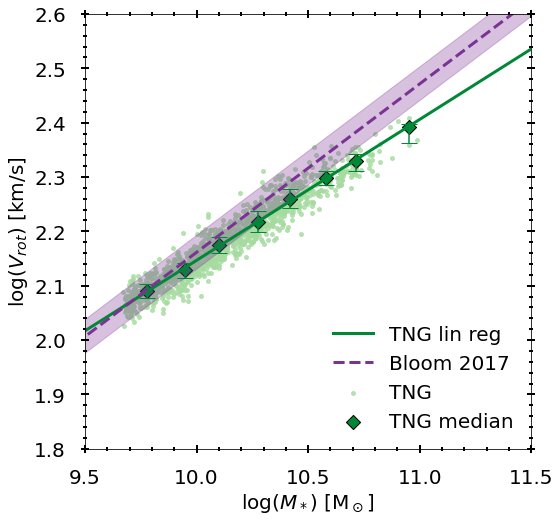

In [27]:
fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (8,8))

x_vals_1 = new_lates_log["SubhaloMassStellar30kpc"].values
x_vals_2 = old_lates_log["SubhaloMassInRadStellar"].values
y_vals_1 = new_lates_log["SubhaloRotVel2_2Re"].values
y_vals_2 = old_lates_log["SubhaloVmax"].values

#Calculate median values + percentiles
x_med1, y_med1, x_err1, y_err1 = il.stats.median_errors(x_vals_1 , y_vals_1, 9.7, 11, n=9)
x_med2, y_med2, x_err2, y_err2 = il.stats.median_errors(x_vals_2 , y_vals_2, 9.7, 11, n=9)
#x_med3, y_med3, x_err3, y_err3 = il.stats.median_values_df(sami_lates_log, "sami", "mstar", "V_rot", xmin=10.2, xmax=11, n=7, error_out=True)
new_lates_log.plot.scatter(x="SubhaloMassStellar30kpc", y="SubhaloRotVel2_2Re",s=15, label = r"TNG", alpha=0.8, color="#a6dba0", ax = axs)

#Linear regression
regX_TNG1, regY_TNG1 = il.stats.lin_reg(x_med1, y_med1, xmin=9.5, xmax=(11.5))
regX_TNG2, regY_TNG2 = il.stats.lin_reg(x_med2, y_med2, xmin=9.5, xmax=(11.5))
axs.plot(regX_TNG1, regY_TNG1, linewidth = 3, label ="TNG lin reg", color="#008837")
#axs.plot(regX_TNG2, regY_TNG2, linewidth = 3, label ="SF lin reg", color="orange")

#Plot median values
axs.errorbar(x_med1, y_med1, yerr=y_err1, capsize = 8, color="#008837", marker='^', fmt = 'none')
axs.scatter(x_med1, y_med1, marker='D', s=100, color="#008837", edgecolors = "black", label = r"TNG median")

#Bloom 2018
B2018y, B2018x = power_law_log(C=-0.93, a=0.31, xmin = 9, xmax = 11.5)
B2018x = B2018x*h_sami**2/h_tng**2 #converting to same cosmology

axs.plot(np.log10(B2018x), np.log10(B2018y), '--', linewidth = 3, label = r"Bloom 2017", c= "#7b3294")
axs.fill_betweenx(np.log10(B2018y), np.log10(B2018x) -0.1, np.log10(B2018x) +0.1, alpha=0.3, color="#7b3294")


il.formatplot.SM_Vmax(ax=axs, x0=9.5, x1=11.5, y0=1.8, y1=2.6)
plt.savefig("../fig/TFR.png", dpi=300, bbox_inches='tight')

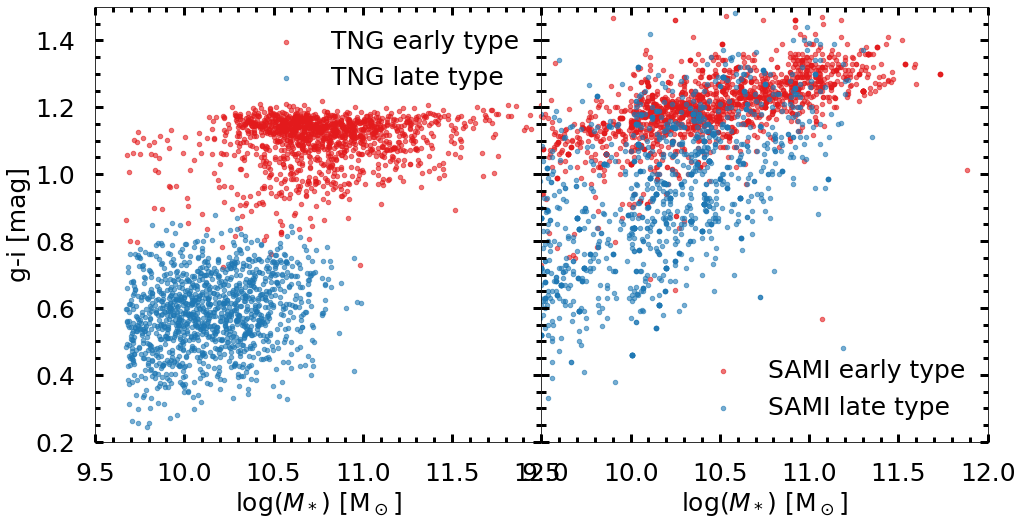

In [32]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize=(16,8), sharey=True, sharex=True, squeeze=True)
#plot
new_earlies_log.plot.scatter(x="SubhaloMassStellar30kpc", y="SubhaloColor_g-i30kpc", color='#e31a1c', s=20, alpha=0.6, ax=axs[0], label ="TNG early type")
new_lates_log.plot.scatter(x="SubhaloMassStellar30kpc", y="SubhaloColor_g-i30kpc", color='#1f78b4', s=20, alpha=0.6, ax=axs[0], label ="TNG late type")
sami_earlies.plot.scatter(x="mstar_log", y="g_i", color='#e31a1c', s=20, alpha=0.6, ax=axs[1], label ="SAMI early type")
sami_lates.plot.scatter(x="mstar_log", y="g_i", color='#1f78b4', s=20, alpha=0.6, ax=axs[1], label ="SAMI late type")
il.formatplot.C_SM(color="g-i", ax=axs[0], y0=0.2, y1=1.5, x0=9.5)
il.formatplot.C_SM(color="g-i", ax=axs[1], y0=0.2, y1=1.5, x0=9.5)
fig.subplots_adjust(hspace=1, wspace=0)
plt.savefig("../fig/results_color_magnitude.png", dpi=300, bbox_inches='tight'c)

In [24]:
print(len(sami_lates[sami_lates["mstar_log"] > 9.5]))

1299


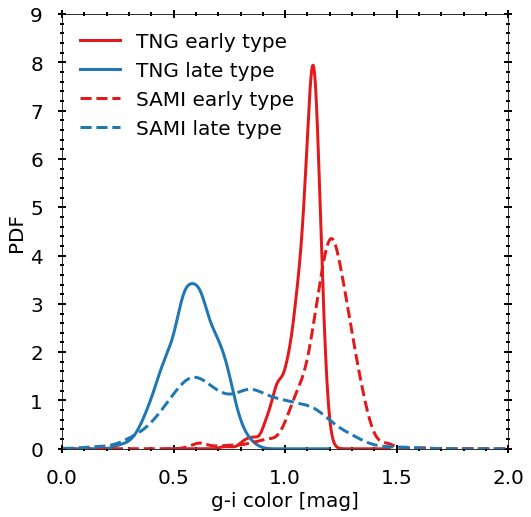

In [25]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (8,8))
sami_late_minmass = sami_lates[sami_lates["mstar_log"] > 9.5]
sami_early_minmass = sami_earlies[sami_earlies["mstar_log"] > 9.5]
ser1, ser2 = old_earlies["SubhaloColor_g-i"], old_lates["SubhaloColor_g-i"]
ser3, ser4 = sami_earlies["g_i"], sami_lates["g_i"]
ser1.plot.kde(ax=ax, color = '#e31a1c', linewidth=3, label="TNG early type")
ser2.plot.kde(ax=ax, color = '#1f78b4', linewidth=3, label="TNG late type")
ser3.plot.kde(ax=ax, label="SAMI early type", color = '#e31a1c', linewidth=3, linestyle="--")
ser4.plot.kde(ax=ax, label="SAMI late type", color = '#1f78b4', linewidth=3, linestyle="--")
il.formatplot.PDF_C('g-i', ax, legend_on=True, x0=0.0, y1=9)
